Question 1:

Download the fashion-MNIST dataset and plot 1 sample image for each class

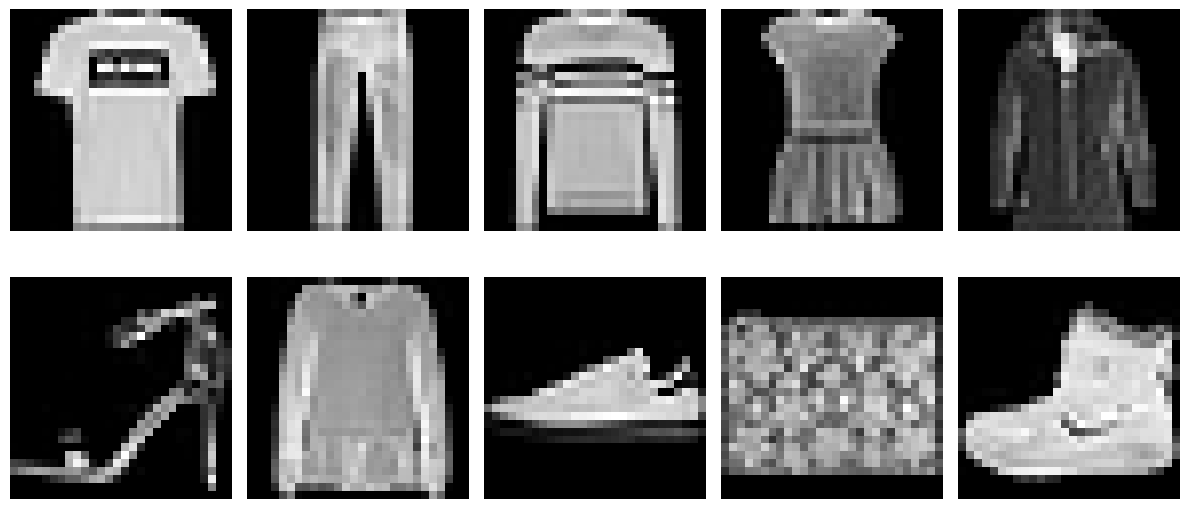

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.datasets import fashion_mnist
# from keras.utils import to_categorical

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

unique_labels=np.unique(y_train)
images=list()
for label in unique_labels:
  images.append(x_train[np.where(y_train==label)[0][0]])

plt.figure(figsize=(12, 6))
for i in range(len(images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

Question 2

In [32]:
class FeedForwardNeuralNetwork:

  def __init__ (self,x_train,y_train,epochs,hls,neurons_in_hl,eta,activation):
    self.epochs=epochs
    self.hls=hls
    self.neurons_in_hl=neurons_in_hl
    self.eta=eta
    self.activation=activation

    self.x_train=self.input_flattening_train(x_train)
    self.y_train=self.one_hot_encoding_train(y_train)


    #initialize W
    W=np.empty((self.hls+1,), dtype=object)
    w_input=np.random.rand(self.neurons_in_hl,self.x_train.shape[1]).astype(np.float128)
    W[0]=w_input
    # W[0] = np.random.randn(self.neurons_in_hl, self.x_train.shape[1]) / np.sqrt(self.x_train.shape[1]).astype(np.float128)
    for i in range(self.hls-1):
      w_hls=np.random.rand(self.neurons_in_hl,self.neurons_in_hl).astype(np.float128)
      W[i+1]=w_hls
      # W[i + 1] = np.random.randn(self.neurons_in_hl, self.neurons_in_hl) / np.sqrt(self.neurons_in_hl).astype(np.float128)
    w_output=np.random.rand(self.y_train.shape[1],self.neurons_in_hl).astype(np.float128)
    W[self.hls]=w_output
    # W[self.hls] = np.random.randn(self.y_train.shape[1], self.neurons_in_hl) / np.sqrt(self.neurons_in_hl).astype(np.float128)

    #initialize B
    B=np.empty((self.hls+1,), dtype=object)
    for i in range(self.hls):
      b_hls=np.random.rand(self.neurons_in_hl).astype(np.float128)
      B[i]=b_hls
      # B[i] = np.random.randn(self.neurons_in_hl) / np.sqrt(self.neurons_in_hl).astype(np.float128)
    b_output=np.random.rand(self.y_train.shape[1]).astype(np.float128)
    B[self.hls]=b_output
    # B[self.hls] = np.random.randn(self.y_train.shape[1]) / np.sqrt(self.neurons_in_hl).astype(np.float128)

    self.W=W
    self.B=B


  def one_hot_encoding_train(self,y_train):
    temp=list()
    for i in range(y_train.shape[0]):
      vector=np.zeros(10)
      vector[y_train[i]]=1
      temp.append(vector)
    return np.array(temp)
    # return to_categorical(y_train)

  def one_hot_encoding_test(self,y_test):
    temp=list()
    for i in range(y_test.shape[0]):
      vector=np.zeros(10)
      vector[y_test[i]]=1
      temp.append(vector)
    return np.array(temp)
    # return to_categorical(y_test)

  def input_flattening_train(self,x_train):
    return x_train.reshape(x_train.shape[0],-1)/255.0#2048.0

  def input_flattening_test(self,x_test):
    return x_test.reshape(x_test.shape[0],-1)/255.0#2048.0

  def sigmoid(self,x):
    return 1/(1+math.exp(-x))

  def grad_sigmoid(self,x):
    return self.sigmoid(x)*(1-self.sigmoid(x))

  def tanh(self,x):
    return math.tanh(x)

  def grad_tanh(self,x):
    return 1-((self.tanh(x))**2)

  def relu(self,x):
    return max(0,x)

  def grad_relu(self,x):
    if x<0:
      return 0
    return 1

  def softmax(self,a):
    max_a=np.max(a)
    exp_a=np.exp(a-max_a)
    sum_exp=np.sum(exp_a)
    return exp_a/sum_exp
    # e=np.exp(a)
    # return e/np.sum(e)

  def update_parameters(self,eta,del_w,del_b):
    for i in range(del_w.shape[0]):
      self.W[i]-=eta*del_w[i]
    for i in range(del_b.shape[0]):
      self.B[i]-=eta*del_b[i]

  def incerement_grad(self,a,x):
    for i in range(a.shape[0]):
      a[i]+=x[i]
    return a


  def forward_propagation(self,w,b,x):
    if(self.activation==1):
      vectorized_activation_func=np.vectorize(self.sigmoid)
    elif(self.activation==2):
      vectorized_activation_func=np.vectorize(self.tanh)
    else:
      vectorized_activation_func=+np.vectorize(self.relu)

    a=np.empty((self.hls+2,), dtype=object)
    h=np.empty((self.hls+2,), dtype=object)

    h[0]=x

    for k in range(1,self.hls+1):
      temp_prod=np.dot(w[k-1],h[k-1])
      # temp_prod=w[k-1] @ h[k-1]
      a[k]=b[k-1]+temp_prod
      h[k]=vectorized_activation_func(a[k])

    temp_prod=np.dot(w[self.hls],h[self.hls])
    a[self.hls+1]=b[self.hls]+temp_prod
    y_cap=self.softmax(a[self.hls+1])

    return a,h,y_cap

  def backward_propagation(self,h,a,y,y_cap):
    if(self.activation==1):
      vectorized_grad_func=np.vectorize(self.grad_sigmoid)
    elif(self.activation==2):
      vectorized_grad_func=np.vectorize(self.grad_tanh)
    else:
      vectorized_grad_func=np.vectorize(self.grad_relu)

    del_a=np.empty((self.hls+2,), dtype=object)
    del_w=np.empty((self.hls+1,), dtype=object)
    del_b=np.empty((self.hls+1,), dtype=object)
    del_h=np.empty((self.hls+2,), dtype=object)

    del_a[self.hls+1]=-(y-y_cap)
    for k in range(self.hls+1,0,-1):
      del_w[k-1]=np.outer(del_a[k],h[k-1])
      del_b[k-1]=del_a[k]
      del_h[k-1]=np.dot(self.W[k-1].T,del_a[k])
      max_gradient=1.0
      del_h[k - 1]=np.clip(del_h[k - 1],-max_gradient,max_gradient)
      if k>1:
        del_a[k-1]=np.multiply(del_h[k-1],vectorized_grad_func(a[k-1]))

    return (del_w,del_b)

  def gradient_descent(self):
    for iter in range(self.epochs):
      del_W,del_B=np.zeros((self.hls+1,), dtype=object),np.zeros((self.hls+1,), dtype=object)
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_W=self.incerement_grad(del_W,ret[0])
        del_B=self.incerement_grad(del_B,ret[1])
        # print()
        # break
      self.update_parameters(self.eta,del_W,del_B)
    return self.W,self.B

  def stochastic_gradient_descent(self):
    for iter in range(self.epochs):
      del_W,del_B=np.zeros((self.hls+1,), dtype=object),np.zeros((self.hls+1,), dtype=object)
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_W=self.incerement_grad(del_W,ret[0])
        del_B=self.incerement_grad(del_B,ret[1])
        # print()
        # break
      self.update_parameters(self.eta,del_W,del_B)
    return self.W,self.B

  # def mini



In [19]:
epochs=2
hls=3
neurons_in_hl=32
eta=10**(-3)
activation=1    #1-sigmoid, 2-tanh, 3-ReLU


Model=FeedForwardNeuralNetwork(x_train,y_train,epochs,hls,neurons_in_hl,eta,activation)
w,b=Model.gradient_descent()
# print(w)

y_test1=Model.one_hot_encoding_test(y_test)
x_test1=Model.input_flattening_test(x_test)
# print(x_test1.shape[0])

accuracy=0
for i in range(x_test1.shape[0]):
  a,h,y_pred=Model.forward_propagation(w,b,x_test1[i])
  print(x_test1[i])
  print(y_pred)
  print()
  if(np.argmax(y_test1[i])==np.argmax(y_pred)):
    accuracy+=1
    # print(i)
  # print(y_pred)

print(accuracy)
print(accuracy/y_test1.shape[0])

#print(Model.W)

AttributeError: 'FeedForwardNeuralNetwork' object has no attribute 'one_hot_encoding_test'

In [48]:
class FeedForwardNeuralNetwork:

  epochs=0
  hls=0
  neurons_in_hl=0
  eta=0.0
  activation=0
  num_of_layers=0
  x_train=np.zeros(784)
  y_train=np.zeros(10)
  W=dict()
  B=dict()

  def __init__ (self,x_train1,y_train1,epochs,hls,neurons_in_hl,eta,activation):
    self.epochs=epochs
    self.hls=hls
    self.neurons_in_hl=neurons_in_hl
    self.eta=eta
    self.activation=activation
    self.num_of_layers=hls+2

    self.x_train=self.input_flattening(x_train1)
    self.y_train=self.one_hot_encoding(y_train1)


    #initialize W
    w=dict()
    w[1]=np.random.randn(self.neurons_in_hl,self.x_train.shape[1])
    # W[0] = np.random.randn(self.neurons_in_hl, self.x_train.shape[1]) / np.sqrt(self.x_train.shape[1]).astype(np.float128)
    for i in range(2,self.num_of_layers-1):
      w[i]=np.random.randn(self.neurons_in_hl,self.neurons_in_hl)
      # W[i + 1] = np.random.randn(self.neurons_in_hl, self.neurons_in_hl) / np.sqrt(self.neurons_in_hl).astype(np.float128)
    w[self.num_of_layers-1]=np.random.randn(self.y_train.shape[1],self.neurons_in_hl)

    # W[self.hls] = np.random.randn(self.y_train.shape[1], self.neurons_in_hl) / np.sqrt(self.neurons_in_hl).astype(np.float128)

    #initialize B
    b=dict()
    for i in range(1,self.num_of_layers-1):
      b[i]=np.random.randn(self.neurons_in_hl)
      # B[i] = np.random.randn(self.neurons_in_hl) / np.sqrt(self.neurons_in_hl).astype(np.float128)
    b[self.num_of_layers-1]=np.random.randn(self.y_train.shape[1])
    # B[self.hls] = np.random.randn(self.y_train.shape[1]) / np.sqrt(self.neurons_in_hl).astype(np.float128)

    self.W=w
    self.B=b


  def one_hot_encoding(self,y):
    temp=list()
    for i in range(y.shape[0]):
      vector=np.zeros(10)
      vector[y[i]]=1
      temp.append(vector)
    return np.array(temp)
    # return to_categorical(y_train)

  # def one_hot_encoding_test(self,y_test):
  #   temp=list()
  #   for i in range(y_test.shape[0]):
  #     vector=np.zeros(10)
  #     vector[y_test[i]]=1
  #     temp.append(vector)
  #   return np.array(temp)
    # return to_categorical(y_test)

  def input_flattening(self,x):
    return x.reshape(x.shape[0],-1)/255.0#2048.0

  # def input_flattening_test(self,x_test):
  #   return x_test.reshape(x_test.shape[0],-1)/255.0#2048.0

  def sigmoid(self,x):
    clipped_x=np.clip(x,-500,500)
    return 1/(1+np.exp(-clipped_x))

  def grad_sigmoid(self,x):
    clipped_x=np.clip(x,-500,500)
    s=1/(1+np.exp(-clipped_x))
    return s*(1-s)

  def tanh(self,x):
    return np.tanh(x)

  def grad_tanh(self,x):
    return 1-(np.tanh(x)**2)

  def relu(self,x):
    return np.maximum(x,0)

  def grad_relu(self,x):
    return 1*(x>0)

  def softmax(self,a):
    # return np.exp(x) / np.sum(np.exp(x), axis=0)
    # max_a=np.max(a)
    # exp_a=np.exp(a-max_a)
    # sum_exp=np.sum(exp_a)
    # return exp_a/sum_exp
    # e=np.exp(a)
    # return e/np.sum(e)
    return np.exp(a)/np.sum(np.exp(a),axis=0)

  def update_parameters(self,eta,del_w,del_b):
    for i in range(1,len(del_w)):
      self.W[i]-=eta*del_w[i]
    for i in range(1,len(del_b)):
      self.B[i]-=eta*del_b[i]

  def update_parameters_mgd(self,del_w,del_b):
    for i in range(1,len(del_w)):
      self.W[i]-=del_w[i]
    for i in range(1,len(del_b)):
      self.B[i]-=del_b[i]

  def incerement_grad(self,a,x):
    for i in range(1,len(a)):
      a[i]+=x[i]
    return a

  def initGrads(self):
    del_w=dict()
    del_w[1]=np.zeros((self.neurons_in_hl,self.x_train.shape[1]), dtype=np.float128)
    for i in range(2,self.num_of_layers-1):
      del_w[i]=np.zeros((self.neurons_in_hl,self.neurons_in_hl), dtype=np.float128)
    del_w[self.num_of_layers-1]=np.zeros((self.y_train.shape[1],self.neurons_in_hl), dtype=np.float128)

    del_b=dict()
    for i in range(1,self.num_of_layers-1):
      del_b[i]=np.zeros(self.neurons_in_hl, dtype=np.float128)
    del_b[self.num_of_layers-1]=np.zeros(self.y_train.shape[1], dtype=np.float128)

    return del_w,del_b

  #def initHistory(self):


  def forward_propagation(self,w,b,x):
    # if(self.activation==1):
    #   vectorized_activation_func=np.vectorize(self.sigmoid)
    # elif(self.activation==2):
    #   vectorized_activation_func=np.vectorize(self.tanh)
    # else:
    #   vectorized_activation_func=+np.vectorize(self.relu)


    h=dict()
    a=dict()

    h[0]=x

    for k in range(1,self.num_of_layers-1):
      # temp_prod=np.dot(self.W[k],h[k-1])
      # temp_prod=w[k-1] @ h[k-1]
      a[k]=b[k]+np.dot(w[k],h[k-1])
      if(self.activation==1):
        h[k]=self.sigmoid(a[k])
      elif(self.activation==2):
        h[k]=self.tanh(a[k])
      else:
        h[k]=self.relu(a[k])

    # temp_prod=np.dot(self.W[self.num_of_layers-1],h[self.num_of_layers-2])
    a[self.num_of_layers-1]=b[self.num_of_layers-1]+np.dot(w[self.num_of_layers-1],h[self.num_of_layers-2])
    y_cap=self.softmax(a[self.hls+1])

    return a,h,y_cap

  def backward_propagation(self,h,a,y,y_cap):
    # if(self.activation==1):
    #   vectorized_grad_func=np.vectorize(self.grad_sigmoid)
    # elif(self.activation==2):
    #   vectorized_grad_func=np.vectorize(self.grad_tanh)
    # else:
    #   vectorized_grad_func=np.vectorize(self.grad_relu)

    # del_a=np.empty((self.hls+2,), dtype=object)
    # del_w=np.empty((self.hls+1,), dtype=object)
    # del_b=np.empty((self.hls+1,), dtype=object)
    # del_h=np.empty((self.hls+2,), dtype=object)
    del_a=dict()
    del_w=dict()
    del_b=dict()
    del_h=dict()

    del_a[self.num_of_layers-1]=-(y-y_cap)
    for k in range(self.num_of_layers-1,0,-1):
      del_w[k]=np.outer(del_a[k],h[k-1])
      del_b[k]=del_a[k]
      del_h[k-1]=np.dot(self.W[k].T,del_a[k])
      # max_gradient=1.0
      # del_h[k - 1]=np.clip(del_h[k - 1],-max_gradient,max_gradient)
      if k>1:
        if(self.activation==1):
          del_a[k-1]=np.multiply(del_h[k-1],self.grad_sigmoid(a[k-1]))
        elif(self.activation==2):
          del_a[k-1]=np.multiply(del_h[k-1],self.grad_tanh(a[k-1]))
        else:
          del_a[k-1]=np.multiply(del_h[k-1],self.grad_relu(a[k-1]))

    return (del_w,del_b)

  def gradient_descent(self):
    for iter in range(self.epochs):
      # del_W,del_B=np.zeros((self.hls+1,), dtype=object),np.zeros((self.hls+1,), dtype=object)
      del_w,del_b=self.initGrads()
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
      self.update_parameters(self.eta,del_w,del_b)
    return self.W,self.B

  def stochastic_gradient_descent(self,batch_size):
    for iter in range(self.epochs):
      # del_W,del_B=np.zeros((self.hls+1,), dtype=object),np.zeros((self.hls+1,), dtype=object)
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          self.update_parameters(self.eta,del_w,del_b)
          del_w,del_b=self.initGrads()
    return self.W,self.B

  def momentum_gradient_descent(self,beta,batch_size):
    prev_uw,prev_ub=self.initGrads()
    for iter in range(self.epochs):
      del_w,del_b=self.initGrads()
      num_of_points_seen=0
      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          uw,ub=dict(),dict()
          for i in range(1,len(del_w)):
            uw[i]=beta*prev_uw[i]+self.eta*del_w[i]
            ub[i]=beta*prev_ub[i]+self.eta*del_b[i]

          self.update_parameters_mgd(uw,ub)
          prev_uw=uw
          prev_ub=ub

    return self.W,self.B

  def nestrov_gradient_descent(self,beta,batch_size):
    prev_uw,prev_ub=self.initGrads()

    for iter in range(self.epochs):
      del_w,del_b=self.initGrads()
      uw,ub=dict(),dict()
      for i in range(1,len(del_w)):
        uw[i]=beta*prev_uw[i]
        ub[i]=beta*prev_ub[i]

      self.update_parameters_mgd(uw,ub)
      num_of_points_seen=0

      for x,y in zip(self.x_train,self.y_train):
        A,H,y_cap=self.forward_propagation(self.W,self.B,x)
        ret=self.backward_propagation(H,A,y,y_cap)
        del_w=self.incerement_grad(del_w,ret[0])
        del_b=self.incerement_grad(del_b,ret[1])
        num_of_points_seen+=1

        if(num_of_points_seen%batch_size==0):
          for i in range(1,len(del_w)):
            uw[i]=beta*prev_uw[i]+self.eta*del_w[i]
            ub[i]=beta*prev_ub[i]+self.eta*del_b[i]

          self.update_parameters_mgd(uw,ub)
          prev_uw=uw
          prev_ub=ub

    return self.W,self.B




In [47]:
epochs=2
hls=3
neurons_in_hl=32
eta=10**(-3)
activation=1    #1-sigmoid, 2-tanh, 3-ReLU


Model=FeedForwardNeuralNetwork(x_train,y_train,epochs,hls,neurons_in_hl,eta,activation)
w,b=Model.nestrov_gradient_descent(0.9,25)
# print(w)

y_test1=Model.one_hot_encoding(y_test)
x_test1=Model.input_flattening(x_test)
# print(x_test1.shape[0])

accuracy=0
for i in range(x_test1.shape[0]):
  a,h,y_pred=Model.forward_propagation(w,b,x_test1[i])
  # print(x_test1[i])
  # print(y_pred)
  # print()
  if(np.argmax(y_test1[i])==np.argmax(y_pred)):
    accuracy+=1
    # print(i)
  # print(y_pred)

print(accuracy)
print(accuracy/y_test1.shape[0])

#print(Model.W)

1000
0.1
